<a href="https://colab.research.google.com/github/DarioMameli/DL_Assignments/blob/main/DL_Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DL Assignment 2
## Group 4
**AUTHORS**:
*   Dario Mameli [dario.mameli@ugent.be]
*   Àngel Masip LLopis [angel.masipllopis@ugent.be]
*   Michele Russo [michele.russo@ugent.be]



This notebook is to be intended as both report and code.

Running on google colab is suggested to make sure all required libraries and packages are present.

# Setup

Firstly let's install and upgrade the necessary packages

In [1]:
!pip install keras --upgrade --quiet
!pip install keras-tuner --upgrade



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 13.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.5 MB/s eta 0:00:00


Let's import all the necessary functions and packages

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import keras
from keras import regularizers
import matplotlib.gridspec as gridspec
from keras.datasets import fashion_mnist
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras.utils import to_categorical
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, confusion_matrix, ConfusionMatrixDisplay
from dl_utils import plot_history
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score


Check the versions of the packages

In [ ]:
print(tf.__version__)
print(keras.__version__)

Check the runtime device

In [ ]:
tf.config.list_physical_devices()

# Load data

Load the training and test set and display its shape

Downloading...
From (original): https://drive.google.com/uc?id=18j4OvAlNWX9pfaoiJNgcTEVslksaf4Dw
From (redirected): https://drive.google.com/uc?id=18j4OvAlNWX9pfaoiJNgcTEVslksaf4Dw&confirm=t&uuid=22c56ad9-8ef3-4c2d-9413-929a285c7722
To: /content/file.zip
100%|██████████| 239M/239M [00:02<00:00, 86.4MB/s]


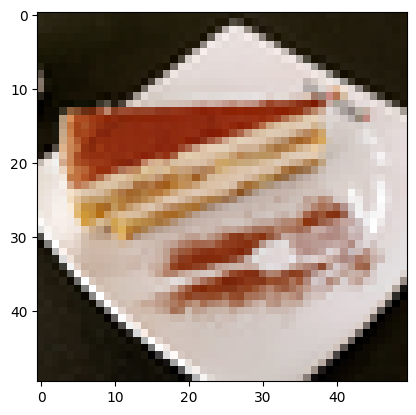

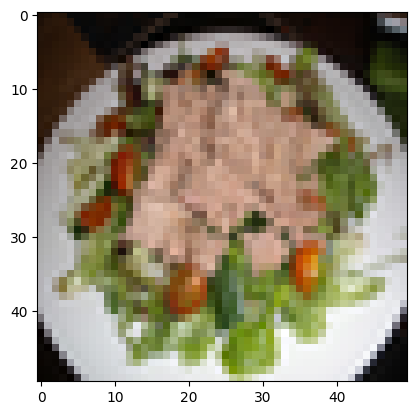

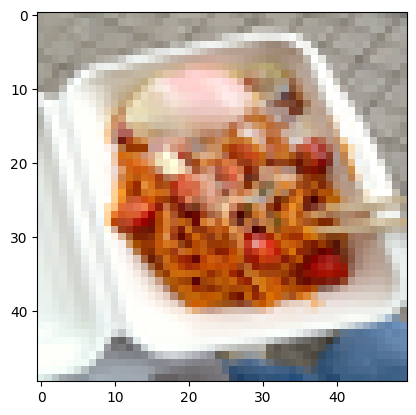

In [3]:
import gdown
import zipfile
import os
from PIL import Image
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Google Drive file ID of your zip file
file_id = '18j4OvAlNWX9pfaoiJNgcTEVslksaf4Dw'
# URL for downloading the file from Google Drive
url = f'https://drive.google.com/uc?id={file_id}'
# Destination path for the downloaded zip file (in Google Colab)
zip_file_path = '/content/file.zip'
# Download the file
gdown.download(url, zip_file_path, quiet=False)
# Extract the contents of the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('/content/extracted_folder')

# Define the paths for X and y
X = []
y = []

# Iterate through the extracted folder
for root, dirs, files in os.walk('/content/extracted_folder/images'):
    for folder_name in dirs:
        folder_path = os.path.join(root, folder_name)

        # Sort the list of files to ensure a consistent order
        file_list = sorted(os.listdir(folder_path))

        # Iterate through sorted images in each folder
        for image_file in file_list:
            image_path = os.path.join(folder_path, image_file)

            # Load the image and convert it to a numpy array if needed
            img = Image.open(image_path)
            img_array = np.array(img)
            X.append(img)
            y.append(folder_name)

# Convert y to numerical labels using LabelEncoder from sklearn
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Resizing all the images
resized_images = []
# Define the target size
width = 50
height = 50
target_size = (width, height)

# Resize each image to the target size using LANCZOS resampling
for img in X:
    resized_img = img.resize(target_size, Image.LANCZOS)
    resized_images.append(resized_img)
# Convert the list of resized images to a NumPy array
X_array = np.array([np.array(img) for img in resized_images])
plt.imshow(X_array[1000])
plt.show()
plt.imshow(X_array[500])
plt.show()
plt.imshow(X_array[0])
plt.show()

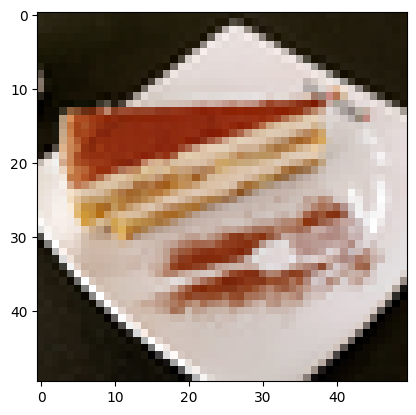

In [4]:
# Display the first resized image
plt.imshow(X_array[1000])
plt.show()


In [5]:
SEED=33
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_array, y, test_size=0.2, random_state=SEED)

Preprocess the feature vectors (normalize data)

In [6]:
# Input data preprocessing
print(np.min(X_train), np.max(y_train))
X_train = X_train.astype("float32")
X_test = X_test.astype("float32")

#normalization
X_train /= 255
X_test /= 255

print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

0 4
1154 train samples
289 test samples


Preprocess the labels (one-hot encodings)

In [7]:
# Labels preprocessing
min = np.min(y_train)
max = np.max(y_train)
print(min, max)
num_classes = max + 1

y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

print("First label is now = ", y_train[0])

0 4
First label is now =  [0. 1. 0. 0. 0.]


## Validation data
Split training data into training and validation data, so that a full training-validation-test split is obtained, for maximizing the generalization performance.

In [8]:
# Split training data into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=SEED) # for reproducibility

##Build a Baseline model

In [17]:
def CNNModel(num_classes):
    model = Sequential()
    model.add(Conv2D(16, (3, 3), activation='relu', input_shape=(50, 50, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [18]:
num_classes = 5
model = CNNModel(num_classes)
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 48, 48, 16)          │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 24, 24, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 22, 22, 32)          │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 11, 11, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 3872)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │         495,744 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 501,477 (1.91 MB)

 Trainable params: 501,477 (1.91 MB)

 Non-trainable params: 0 (0.00 B)

##Our Model

In [11]:
class MyCNNModel(kt.HyperModel):
    def __init__(self, loss="categorical_crossentropy"):
        self.loss = loss

    def build(self, hp):
        model = self.build_CNN(hp)
        return model

    def build_CNN(self, hp):
        hp_units1 = hp.Int('unitsL1', min_value=16, max_value=256, step=16)
        hp_units2 = hp.Int('unitsL2', min_value=16, max_value=256, step=16)
        hp_activation = hp.Choice("activation", ["gelu", "tanh", "relu"])
        hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
        hp_dropout_rate = hp.Float('dropout_rate', min_value=0.0, max_value=0.5, step=0.1)
        hp_optimizer = hp.Choice('optimizer', values=['adam'])

        model = self.build_CNN_hp(
            hp_units1=hp_units1, hp_units2=hp_units2, hp_activation=hp_activation,
            hp_learning_rate=hp_learning_rate, hp_optimizer=hp_optimizer, hp_dropout_rate=hp_dropout_rate
        )
        return model

    def build_CNN_hp(self, hp_units1, hp_units2, hp_activation, hp_learning_rate,
                     hp_optimizer, hp_dropout_rate):
        model = Sequential()
        model.add(Conv2D(hp_units1, (3, 3), activation=hp_activation, input_shape=(50, 50, 3)))
        model.add(MaxPooling2D((2, 2)))
        model.add(Conv2D(hp_units2, (3, 3), activation=hp_activation))
        model.add(MaxPooling2D((2, 2)))
        model.add(Flatten())
        model.add(Dense(hp_units1, activation=hp_activation))
        model.add(Dropout(hp_dropout_rate))
        model.add(Dense(hp_units2, activation=hp_activation))
        model.add(Dropout(hp_dropout_rate))
        model.add(Dense(5, activation="softmax"))

        optimizer = Adam(learning_rate=hp_learning_rate)
        loss = "categorical_crossentropy"

        model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
        return model

    def fit(self, hp, model, *args, **kwargs):
        datagen_train = ImageDataGenerator(
           rotation_range=10,
           width_shift_range=0.1,
            height_shift_range=0.1,
           shear_range=0.2,
           zoom_range=0.2,
            horizontal_flip=True,
            vertical_flip=True,
            fill_mode='nearest'
        )


        datagen_train.fit(X_train)

        datagen_val = ImageDataGenerator(
          rotation_range=10,
          width_shift_range=0.1,
          height_shift_range=0.1,
          shear_range=0.2,
          zoom_range=0.2,
          horizontal_flip=True,
          vertical_flip=True,
          fill_mode='nearest'
        )


        datagen_val.fit(X_val)

        return model.fit(
            datagen_train.flow(X_train, y_train, batch_size=128, shuffle=True),
            validation_data=datagen_val.flow(X_val, y_val, batch_size=128, shuffle=True)
        )


In [12]:
# Define the hyperband tuner object, passing the model where to perform the search
tuner = kt.Hyperband(MyCNNModel(),
                     objective='val_accuracy',
                     max_epochs=20,

                     max_consecutive_failed_trials=5,
                     project_name='my_cnn_tuning',
                     directory='my_cnn_tuning',
)

# Summarize the search space
tuner.search_space_summary()


Search space summary
Default search space size: 6
unitsL1 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
unitsL2 (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 256, 'step': 16, 'sampling': 'linear'}
activation (Choice)
{'default': 'gelu', 'conditions': [], 'values': ['gelu', 'tanh', 'relu'], 'ordered': False}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
dropout_rate (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': 'linear'}
optimizer (Choice)
{'default': 'adam', 'conditions': [], 'values': ['adam'], 'ordered': False}


# Training


## Baseline's training

Here we train the baseline model using the same parameters specified in the lab.

In [13]:
batch_size = 128
epochs = 5


Epoch 1/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 11s 875ms/step - accuracy: 0.2604 - loss: 1.5898 - val_accuracy: 0.5671 - val_loss: 1.4336
Epoch 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5283 - loss: 1.3846 - val_accuracy: 0.6017 - val_loss: 1.1982
Epoch 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5624 - loss: 1.1821 - val_accuracy: 0.5974 - val_loss: 1.0802
Epoch 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6042 - loss: 1.0431 - val_accuracy: 0.6234 - val_loss: 0.9804
Epoch 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6389 - loss: 0.9620 - val_accuracy: 0.6104 - val_loss: 0.9545


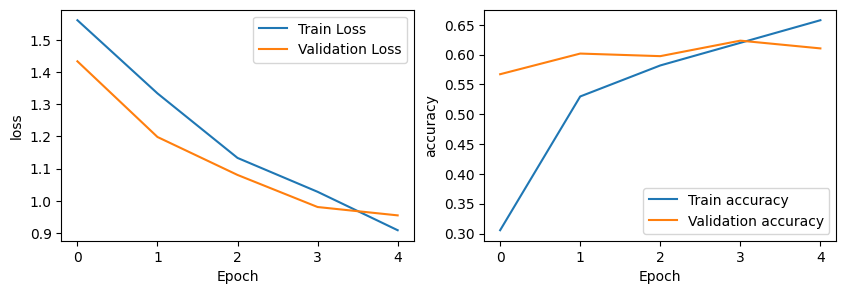

In [14]:
# Fit the model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_val, y_val))
plot_history(history)

Save the baseline model in the workspace

In [15]:
model.save('/content/baseline_model.keras')

In [ ]:
print("Original shape of X_train:", X_train.shape)


Original shape of X_train: (923, 50, 50, 3)


## Training the best model


Trial 28 Complete [00h 00m 12s]
val_accuracy: 0.18614718317985535

Best val_accuracy So Far: 0.5021644830703735
Total elapsed time: 00h 06m 59s
Epoch 1/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 10s 161ms/step - accuracy: 0.2520 - loss: 1.5946 - val_accuracy: 0.4069 - val_loss: 1.3822
Epoch 2/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4624 - loss: 1.3617 - val_accuracy: 0.6494 - val_loss: 1.1518
Epoch 3/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5578 - loss: 1.1954 - val_accuracy: 0.6623 - val_loss: 1.0161
Epoch 4/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6006 - loss: 1.0603 - val_accuracy: 0.6710 - val_loss: 0.9316
Epoch 5/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6306 - loss: 0.9992 - val_accuracy: 0.6580 - val_loss: 0.8745
Epoch 6/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6836 - loss: 0.9219 - val_accuracy: 0.7056 - val_loss: 0.8019
Epoch 7/50
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6794 - loss: 0.8611 - val_accurac

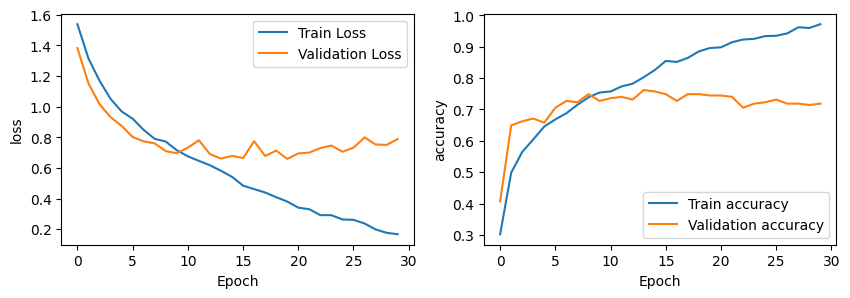

Best epoch: 14


In [16]:
# Early stop to prevent overfitting
stop_early = tf.keras.callbacks.EarlyStopping(
  monitor="val_loss",
  min_delta=0,
  patience=10,
  verbose=0,
  mode="auto",
  baseline=None,
  restore_best_weights=True,
  start_from_epoch=5,
)

# Perform the search
tuner.search(X_train, y_train, validation_data=(X_val, y_val), callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

# Build the model with the optimal hyperparameters and train it on the data for maximum 50 epochs
best_model = tuner.hypermodel.build(best_hps)
history = best_model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), callbacks=[stop_early])

# Plot the training summary
plot_history(history)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = np.argmax(val_acc_per_epoch) + 1
print('Best epoch: %d' % (best_epoch,))

Save the best model in the workspace

In [19]:
best_model.save('/content/best_model.keras')